In [1]:
# PROCESS THE GLOBULAR CLUSTER STARS CATAOLOG:
# https://zenodo.org/records/4891252
#
#
# ZACK REEVES
# CREATED: 2024
#
# VERSIONS:
#  1.1  JAN 2024 CREATE JUPYTER NOTEBOOK

In [14]:
import pandas as pd
import numpy as np
import sys
import os
import collections

from tqdm import tqdm

from astropy.io import ascii
import astropy.units as u
import astropy.coordinates
from astropy.table import unique, vstack, Table, join

from astroquery.gaia import Gaia

sys.path.insert(0, '..')
from common import file_functions, calculations, gaia_functions, get_bailer_jones

from matplotlib import pyplot as plt, colors

In [3]:
# Define the metadata for the data set. #FIX LATER
metadata = {}

metadata['project'] = 'Digital Universe Atlas Gaia Subsets'
metadata['sub_project'] = 'Gaia Stars in Globular Clusters'

metadata['catalog'] = 'Catalogue of stars in Milky Way globular clusters from Gaia EDR3 (Vasiliev+, 2021)'
metadata['catalog_author'] = 'Vasiliev+'
metadata['catalog_year'] = '2021'
metadata['catalog_doi'] = 'https://doi.org/10.5281/zenodo.4891252'
metadata['catalog_bibcode'] = '10.5281/zenodo.4891252'

metadata['prepared_by'] = 'Brian Abbott, Zack Reeves'
metadata['version'] = '1.1'

metadata['dir'] = metadata['sub_project'].replace(' ', '_').lower()
metadata['raw_data_dir'] = ''

metadata['data_group_title'] = 'Gaia Globular Cluster Stars'
metadata['data_group_desc'] = 'Stars in the Milky Way identified to be members of globular clusters'
metadata['data_group_desc_long'] = ''
metadata['fileroot'] = 'globstars'

file_functions.generate_license_file(metadata)
file_functions.generate_asset_file(metadata)

In [4]:
#download data from https://zenodo.org/records/4891252

In [16]:
#reading in the data

#data are downloaded in a .zip file.  Once extracted, the stars associated with each cluster are stored in folders
#named by the cluster.  We combine each of these folders into one table with an appended column describing the
#cluster

#iterate through files in catalogues directory and stack

directory_str = 'raw_data/clusters/catalogues/'
directory = os.fsencode(directory_str)
    
tables=[]
for file in tqdm(os.listdir(directory)):
    filename = os.fsdecode(file)
    if filename.endswith(".txt"):
        #reading in the table
        table = ascii.read(directory_str+filename)
        #adding a column with the cluster name
        table['cluster_name'] = table.Column(data=[filename[:len(filename)-4]]*len(table),
                                             meta = collections.OrderedDict([('ucd', 'meta.name.cluster')]),
                                             description='Name of associated Globular Cluster')
        #adding table to array for stacking
        tables.append(table)

100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [11:41<00:00,  4.13s/it]


In [23]:
#combining tables in tables array
data = vstack(tables)
data

source_id,ra,dec,x,y,plx,pmra,pmdec,plxe,pmrae,pmdece,pmcorr,g_mag,bp_rp,Sigma,qflag,memberprob,cluster_name
str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,str15
4829785385431810560,58.761525,-49.645388,0.0013,-0.0301,-0.7466,-0.2551,-2.6741,0.8455,0.6714,1.1889,0.071,20.6461,0.9471,1.059,3,0.9606,AM_1
4829785389727698688,58.751714,-49.646782,-0.0051,-0.0315,2.7071,4.6897,-25.359,0.1229,0.1314,0.1744,-0.1839,18.4849,2.6622,0.9764,3,0.0,AM_1
4829785385431812992,58.748515,-49.642957,-0.0072,-0.0277,1.1334,3.102,-3.0671,0.5935,0.6316,0.9969,-0.3091,20.5257,0.9007,1.146,2,0.00026,AM_1
4829785522870771200,58.711829,-49.639222,-0.0309,-0.024,0.7026,-2.8045,1.0433,0.8622,1.499,1.4694,-0.1802,20.7759,1.3373,0.7479,3,0.51338,AM_1
4829773947934874496,58.791386,-49.650119,0.0206,-0.0348,-0.0517,1.3742,-0.9804,0.3993,0.4761,0.5536,-0.1824,20.1028,0.6014,0.7152,3,0.91755,AM_1
4829774085373770624,58.816696,-49.634441,0.037,-0.0192,1.359,20.5965,20.4528,0.7439,0.7211,1.0011,-0.2158,19.2963,2.2922,0.688,0,0.0,AM_1
4829773982294556160,58.806048,-49.633596,0.0301,-0.0183,1.6977,7.9558,19.2337,0.0112,0.0126,0.0154,-0.1949,12.988,0.7496,0.8556,1,0.0,AM_1
4829785836404292992,58.803704,-49.627975,0.0286,-0.0127,1.4172,65.2717,-11.243,0.0255,0.0283,0.0372,-0.2458,15.6528,1.098,1.004,1,0.0,AM_1
4829785385431819648,58.750954,-49.638972,-0.0056,-0.0237,-0.2818,-0.0047,0.0801,0.2636,0.2863,0.3934,-0.2355,19.714,0.7056,1.514,3,0.99988,AM_1


In [24]:
data['source_id'] = [int(i) for i in data['source_id']]

In [25]:
#renaming columns 'x' and 'y' to not be confused with cartesian x and y and adding clarification
data.rename_column('x', 'cluster_x')
data['cluster_x'].description ='X coordinate centered on cluster'
data.rename_column('y', 'cluster_y')
data['cluster_y'].description ='Y coordinate centered on cluster'

#removing proper motion columns because we'll get them from Gaia DR3
data.remove_column('pmra')
data.remove_column('pmdec')

#removing rows with parallax <=0.0 and rows with memberprob < 0.5
data.remove_rows(np.where(data['plx']<=0.0)[0])
data.remove_rows(np.where(data['memberprob']<0.5)[0])

In [27]:
data.write('gc.fits', overwrite=True)

In [ ]:
#data = Table.read('gc.fits')

In [29]:
distances = get_bailer_jones.get_bj_distances(data, get_motion=True)

INFO: Login to gaia TAP server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to gaia data server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Sending pytable. [astroquery.utils.tap.core]
INFO: Uploaded table 'gaia_ids'. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Table 'gaia_ids' deleted. [astroquery.utils.tap.core]
INFO: Removed jobs: '1721447580760O'. [astroquery.utils.tap.core]
INFO: Gaia TAP server logout OK [astroquery.gaia.core]
INFO: Gaia data server logout OK [astroquery.gaia.core]


In [30]:
data = join(data, distances, keys='source_id', join_type='left')
data

source_id,ra,dec,cluster_x,cluster_y,plx,plxe,pmrae,pmdece,pmcorr,g_mag,bp_rp,Sigma,qflag,memberprob,cluster_name,parallax,parallax_error,pmra,pmdec,radial_velocity,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo,bj_distance,dcalc,e_bj_dist,bj_error_over_distance
,,,,,,,,,,,,,,,,mas,mas,mas / yr,mas / yr,km / s,pc,pc,pc,pc,pc,pc,pc,,pc,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,str15,float64,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64
159501547637156224,71.51138,31.350682,-0.0113,-0.0308,1.2437,0.6005,0.777,0.6146,0.2396,20.0605,2.1708,10.06,2,0.57425,Pal_2,1.243963963123851,0.6004813,1.0714211277035552,-1.3183192058131075,--,1894.8824,3319.195,1014.4835,2083.7034,2721.644,1819.6149,2083.7034,1,451.01458740234375,0.2164485569691977
159501586292411776,71.523145,31.355986,-0.0013,-0.0255,1.3454,0.9036,1.3053,0.9417,0.1647,20.4477,1.7141,13.89,2,0.7056,Pal_2,1.332067740578626,0.9035593,0.19450881760742672,-1.0074072002350758,--,1402.9673,2177.2969,875.86127,4151.568,4846.3735,3572.756,4151.568,1,636.8087158203125,0.15338993257324304
159501586292412288,71.516286,31.357777,-0.0071,-0.0237,0.2818,1.3668,1.8071,1.3501,0.3341,20.5715,2.0812,14.49,0,0.66133,Pal_2,0.25809036897508,1.3667847,2.287536528932165,1.1161745736258242,--,2487.9849,3831.4065,1254.0636,2878.1316,3601.5107,2550.4177,2878.1316,1,525.5465087890625,0.182599888860868
159501586292963200,71.525228,31.359972,0.0005,-0.0215,0.0346,0.3308,0.3755,0.3023,-0.0392,19.3274,2.6935,18.19,2,0.98728,Pal_2,0.016371028164813155,0.3307884,1.2813790091588988,-1.7047067727289518,--,4311.292,8385.011,2305.2332,1014.93994,1517.9391,883.3095,1014.93994,1,317.3147888183594,0.3126439071643036
159501586292964352,71.516123,31.3589,-0.0073,-0.0226,0.2237,0.3176,0.3701,0.2978,0.1035,19.2022,1.6768,15.42,3,0.97019,Pal_2,0.20870282125022963,0.31755328,1.1721832004023987,-1.7947624541203158,--,2382.0242,3542.7734,1687.5037,2864.8809,3847.298,2325.7483,2864.8809,1,760.77490234375,0.2655520210741748
159501650715977600,71.550888,31.3634,0.0224,-0.0181,0.0619,0.1532,0.1681,0.1328,0.1675,17.8953,2.5126,11.92,3,0.99651,Pal_2,0.027913769997799202,0.15324143,1.1892825433774734,-1.5618312656372937,--,4006.4885,5476.6,2829.8552,3335.1077,3696.4226,2477.0713,3335.1077,1,609.6756591796875,0.1828053904802578
159501650715980416,71.545134,31.365569,0.0175,-0.0159,0.1594,0.2282,0.2728,0.2196,0.1413,18.7062,2.2034,15.48,3,0.99148,Pal_2,0.13977026059604541,0.22822945,0.9328294585958732,-1.449334770999215,--,4049.8425,6042.531,2320.2788,2118.2573,2645.3796,1695.7231,2118.2573,1,474.8282470703125,0.22415985142194061
159501650715989504,71.556921,31.371705,0.0276,-0.0098,0.0901,0.1513,0.1776,0.1372,0.2521,18.039,2.4902,11.69,3,0.99657,Pal_2,0.0591514335376898,0.15125853,1.0626129493365912,-1.5901208026035942,--,3695.623,5187.964,2768.1565,3477.9958,4177.392,2442.3296,3477.9958,1,867.53125,0.24943423957720803


In [31]:
data['cluster_name'] = table.Column(data=data['cluster_name'],
                                         meta = collections.OrderedDict([('ucd', 'meta.name.cluster')]),
                                         description='Name of associated Globular Cluster')

In [32]:
#fixing parallax units
data['plx'].unit=u.mas

#fixing RA/Dec units
data['ra'].unit=u.deg
data['dec'].unit=u.deg

In [33]:
#calculating distance in light years and parsecs
calculations.get_distance(data, dist='bj_distance', use='distance')

In [34]:
#calculating cartesian coordinates
calculations.get_cartesian(data, ra='ra', dec='dec', pmra='pmra', pmde='pmdec', frame='icrs')

<function matplotlib.pyplot.show(close=None, block=None)>

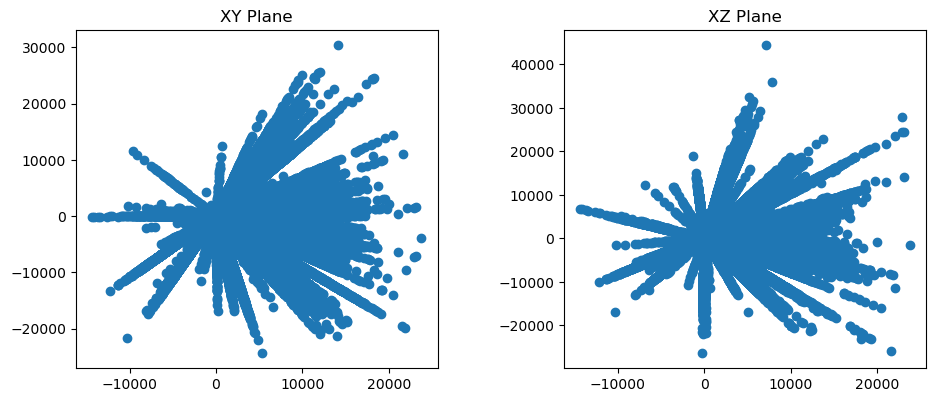

In [35]:
#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(data['x'], data['y'])
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(data['x'], data['z'])
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

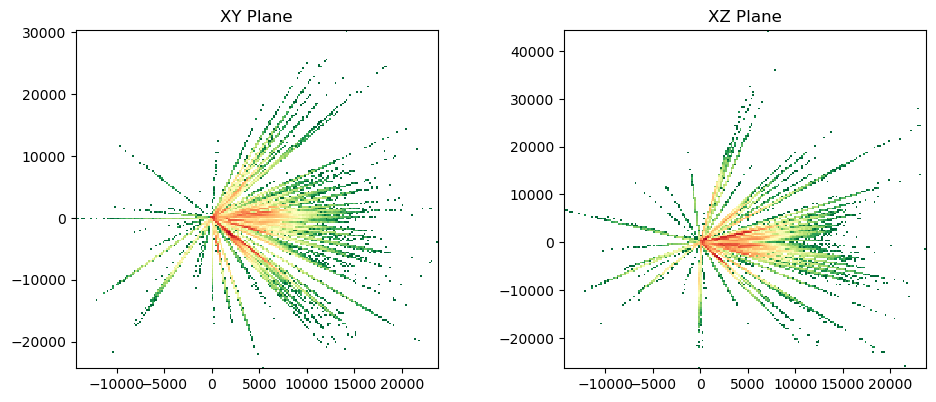

In [36]:
#2D Density Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].hist2d(data['x'], data['y'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].hist2d(data['x'], data['z'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
#plt.show

In [37]:
gaia_functions.get_magnitudes(data, gmag='g_mag')
gaia_functions.get_luminosity(data)
gaia_functions.get_bp_g_color(data, color='bp_rp')

In [38]:
#construct a speck comment column
data['speck_label'] = data.Column(data=['#__'+str(name) for name in data['source_id']], 
                                  meta=collections.OrderedDict([('ucd', 'meta.id')]),
                                  description='Gaia EDR3 Source ID')

#construct a label column
data['label'] = ['GaiaEDR3_'+ str(source) for source in data['source_id']]  #leaving for now in case we want to add other labels

#setting texture number column
data['texnum'] = data.Column(data=[1]*len(data), 
                                  meta=collections.OrderedDict([('ucd', 'meta.texnum')]),
                                  description='Texture Number')

In [39]:
#Getting the column metadata
columns = file_functions.get_metadata(data, columns=['x', 'y', 'z', 'color', 'lum', 'absmag', 'appmag', 'texnum', 'dist_ly', 'dcalc', 'u', 'v', 'w', 'speed', 'cluster_name', 'speck_label'])
columns

,name,unit,datatype,width,precision,arraysize,ucd,description
0,x,pc,float64,,6,,pos.cartesian.x,x position (galactic cartesian coordinates) in...
1,y,pc,float64,,6,,pos.cartesian.y,Position (y coordinate) in parsecs
2,z,pc,float64,,6,,pos.cartesian.z,Position (z coordinate) in parsecs
3,color,solLum,float64,,2,,phys.color,Gaia BP-G color
4,lum,solLum,float64,,6,,phys.luminosity,Stellar Luminosity
5,absmag,mag,float64,,6,,phot.magAbs;em.opt.G,Absolute magnitude in Gaia G-band
6,appmag,mag,float64,,6,,phot.mag;em.opt.G,Apparent magnitude in Gaia G-band
7,texnum,,int32,,,,meta.texnum,Texture Number
8,dist_ly,lyr,float32,,1,,pos.distance,Distance from Sun (lyr)
9,dcalc,,int32,,,,meta.dist,Distance indicator: 1 indicates a Bailer-Jones...


In [40]:
# Print the csv file using the to_speck function in file_functions
file_functions.to_csv(metadata, Table.to_pandas(data), columns)

# Print the speck file using the to_speck function in file_functions
file_functions.to_speck(metadata, Table.to_pandas(data), columns)

# Print the label file using the to_label function in file_functions
file_functions.to_label(metadata, Table.to_pandas(data))

In [41]:
cluster_names = unique(data, keys='cluster_name')['cluster_name']

In [42]:
for i in cluster_names:
    print(i)

AM_1
AM_4
Arp_2
BH_140
BH_176
BH_261_AL_3
Bliss_1
Crater
Djorg_1
Djorg_2_ESO456-
ESO280-06
ESO452-11
ESO_93-8
E_3
Eridanus
FSR_1716
FSR_1735
FSR_1758
Gran_1
HP_1_BH_229
IC_1257
IC_1276_Pal_7
IC_4499
Kim_3
Ko_1
Ko_2
Laevens_3
Liller_1
Lynga_7_BH184
Mercer_5
Munoz_1
NGC_104_47Tuc
NGC_1261
NGC_1851
NGC_1904_M_79
NGC_2298
NGC_2419
NGC_2808
NGC_288
NGC_3201
NGC_362
NGC_4147
NGC_4372
NGC_4590_M_68
NGC_4833
NGC_5024_M_53
NGC_5053
NGC_5139_oCen
NGC_5272_M_3
NGC_5286
NGC_5466
NGC_5634
NGC_5694
NGC_5824
NGC_5897
NGC_5904_M_5
NGC_5927
NGC_5946
NGC_5986
NGC_6093_M_80
NGC_6101
NGC_6121_M_4
NGC_6139
NGC_6144
NGC_6171_M107
NGC_6205_M_13
NGC_6218_M_12
NGC_6229
NGC_6235
NGC_6254_M_10
NGC_6256
NGC_6266_M_62
NGC_6273_M_19
NGC_6284
NGC_6287
NGC_6293
NGC_6304
NGC_6316
NGC_6325
NGC_6333_M_9
NGC_6341_M_92
NGC_6342
NGC_6352
NGC_6355
NGC_6356
NGC_6362
NGC_6366
NGC_6380_Ton1
NGC_6388
NGC_6397
NGC_6401
NGC_6402_M_14
NGC_6426
NGC_6440
NGC_6441
NGC_6453
NGC_6496
NGC_6517
NGC_6522
NGC_6528
NGC_6535
NGC_6539
NGC_654

In [43]:
#the distances given for the stars in globular clusters are inaccurate due to local motions within the clusters
#we disect the dataset back into its constituent clusters to artificially constrain the stars in each cluster to the hypothetical cluster radius

In [44]:
# from astroquery.vizier import Vizier
# #reading in the catalogue
# catalog = Vizier(catalog='J/MNRAS/505/5978', columns=['**'], row_limit=-1).query_constraints()
# clusters = catalog[0]

In [45]:
# The table read in the commented out code in the previous cell usefully provides the mean parallaxes of each cluster
# The cluster names in that table don't exactly match the ones we have, so the following table is a custom correlation table
clusters = Table.read('globclusters.csv')
clusters

col0,recno,Name,OName,RAJ2000,DEJ2000,pmRA,e_pmRA,pmDE,e_pmDE,corr,plx,e_plx,Rscale,Nstar,SimbadName,dist_pc,cluster_name,_1,_2,_3
int32,int32,str12,str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,str26,float64,str15,int32,int32,int32
0,37,AM 4,--,209.09,-27.167,-0.291,0.445,-2.512,0.344,-0.36,0.079,0.343,0.39,8,AM 4,12658.228,AM_4,--,--,--
1,154,Arp 2,--,292.184,-30.356,-2.331,0.031,-1.475,0.029,0.05,0.026,0.021,1.66,156,Arp 2,38461.54,Arp_2,--,--,--
2,29,BH 140,--,193.473,-67.177,-14.848,0.024,1.224,0.024,0.0,0.219,0.011,4.41,1197,Cl VDBH 140,4566.21,BH_140,--,--,--
3,49,BH 176,--,234.781,-50.05,-3.989,0.029,-3.057,0.029,-0.02,0.072,0.018,1.34,90,Cl VDBH 176,13888.89,BH_176,--,--,--
4,53,BH 184,Lynga 7,242.765,-55.318,-3.851,0.027,-7.05,0.027,0.02,0.121,0.012,2.0,147,Cl VDBH 184,8264.463,Lynga_7_BH184,--,--,--
5,89,BH 229,HP 1,262.772,-29.982,2.523,0.039,-10.093,0.037,0.04,0.124,0.014,0.93,25,Cl VDBH 229,8064.516,HP_1_BH_229,--,--,--
6,131,BH 261,ESO 456-78,273.527,-28.635,3.566,0.043,-3.59,0.037,0.1,0.191,0.023,0.74,21,Cl VDBH 261,5235.602,BH_261_AL_3,--,--,--
7,23,Bliss 1,--,177.511,-41.772,-2.34,0.042,0.138,0.038,-0.16,0.025,0.039,0.62,10,--,40000.0,Bliss_1,--,--,--
8,22,Crater,Laevens 1,174.067,-10.877,-0.059,0.125,-0.116,0.116,-0.23,0.003,0.142,0.51,15,NAME Crater Cluster,333333.3,Crater,--,--,--


In [46]:
def angle_radius(rscale_theta, distance):
    return distance*np.tan(rscale_theta)

In [47]:
import scipy.stats as stats

In [54]:
cluster_dataframes=[]
for i in tqdm(range(len(cluster_names))):
    cluster = cluster_names[i]
    df = data[data['cluster_name']==cluster]
    
    clusters['plx'].unit=u.mas
    
    cluster_parallax = clusters['plx'][clusters['cluster_name']==cluster]
    if(cluster_parallax>0):
        cluster_distance = (clusters['plx'][clusters['cluster_name']==cluster]).to(u.pc, equivalencies=u.parallax())[0]
    else:
        cluster_distance = sum(df['bj_distance']) / len(df)
        
    cluster_radius = angle_radius(clusters['Rscale'][clusters['cluster_name']==cluster], cluster_distance)
    
    #calculating percentiles of the distances of each star in the cluster; we will maintain these percentilesas we narrow the distribution down
    df['dist_percentile'] = [stats.percentileofscore(df['bj_distance'], df['bj_distance'][i], kind='weak') for i in range(len(df))]
    
    #dropping stars which are egregiously far from the cluster (higher than 5 sigma)
    #df.remove_rows(np.where((df['dist_percentile']<(1-0.999999426696856))|(df['dist_percentile']>0.999999426696856))[0])
    
    #mu is the desired distance (the center of the cluster) and sigma will be the adjusted stdev
    mu = cluster_distance
    #we want 95% of our stars within our calculated diameter, so 4*sigma=diameter -> sigma=radius / 2
    sigma = angle_radius(rscale_theta=14.62*u.arcmin, distance=5181.347*u.pc) / 2

    adjusted_distance_distribution = stats.norm(loc=mu, scale=sigma)

    # df['adjusted_distances'] = [adjusted_distance_distribution.ppf(i/100) for i in df['dist_percentile']]
    df['adjusted_distances'] = [adjusted_distance_distribution.ppf(df['dist_percentile'][i]/100) if((df['dist_percentile'][i]<100.0)&(df['dist_percentile'][i]>0.0)) else df['bj_distance'][i] for i in range(len(df))]

    df['adjusted_distances'].unit=u.pc
    
    calculations.get_distance(df, dist='adjusted_distances', use='distance')
    calculations.get_cartesian(df, ra='ra', dec='dec', pmra='pmra', pmde='pmdec', frame='icrs')
    cluster_dataframes.append(df)

100%|████████████████████████████████████████████████████████████████████████████████| 170/170 [03:37<00:00,  1.28s/it]


In [55]:
adjusted_data = vstack(cluster_dataframes)

<function matplotlib.pyplot.show(close=None, block=None)>

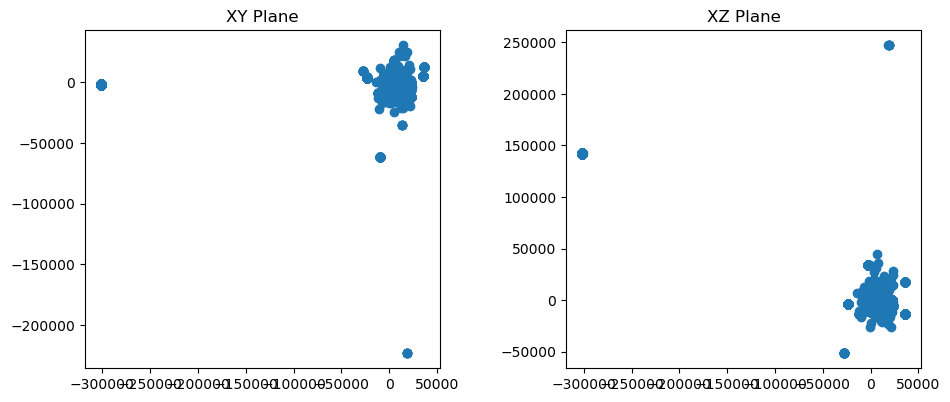

In [56]:
#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(adjusted_data['x'], adjusted_data['y'])
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(adjusted_data['x'], adjusted_data['z'])
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

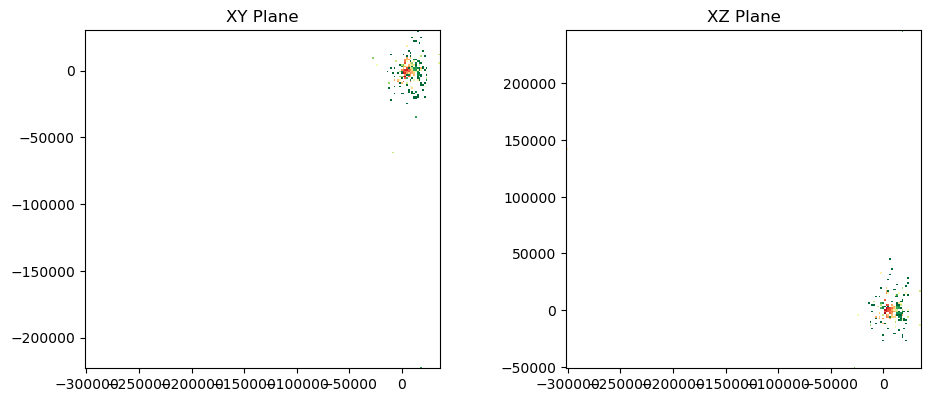

In [57]:
#2D Density Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].hist2d(adjusted_data['x'], adjusted_data['y'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].hist2d(adjusted_data['x'], adjusted_data['z'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
#plt.show

In [58]:
#Getting the column metadata
columns = file_functions.get_metadata(adjusted_data, columns=['x', 'y', 'z', 'color', 'lum', 'absmag', 'appmag', 'texnum', 'dist_ly', 'dcalc', 'u', 'v', 'w', 'speed', 'cluster_name', 'speck_label'])
columns

,name,unit,datatype,width,precision,arraysize,ucd,description
0,x,pc,float64,,6,,pos.cartesian.x,x position (galactic cartesian coordinates) in...
1,y,pc,float64,,6,,pos.cartesian.y,Position (y coordinate) in parsecs
2,z,pc,float64,,6,,pos.cartesian.z,Position (z coordinate) in parsecs
3,color,solLum,float64,,2,,phys.color,Gaia BP-G color
4,lum,solLum,float64,,6,,phys.luminosity,Stellar Luminosity
5,absmag,mag,float64,,6,,phot.magAbs;em.opt.G,Absolute magnitude in Gaia G-band
6,appmag,mag,float64,,6,,phot.mag;em.opt.G,Apparent magnitude in Gaia G-band
7,texnum,,int32,,,,meta.texnum,Texture Number
8,dist_ly,lyr,float64,,1,,pos.distance,Distance from Sun (lyr)
9,dcalc,,int32,,,,meta.dist,Distance indicator: 1 indicates a Bailer-Jones...


In [ ]:
adjusted_data

In [65]:
# Print the csv file using the to_speck function in file_functions
file_functions.to_csv(metadata, Table.to_pandas(adjusted_data), columns, filename='fixed_gc.csv')

# Print the speck file using the to_speck function in file_functions
file_functions.to_speck(metadata, Table.to_pandas(adjusted_data), columns)

# Print the label file using the to_label function in file_functions
file_functions.to_label(metadata, Table.to_pandas(adjusted_data))

In [60]:
max(adjusted_data['dist_pc'])

333366.35074651137

In [61]:
adjusted_data[adjusted_data['dist_pc']>300000]

source_id,ra,dec,cluster_x,cluster_y,plx,plxe,pmrae,pmdece,pmcorr,g_mag,bp_rp,Sigma,qflag,memberprob,cluster_name,parallax,parallax_error,pmra,pmdec,radial_velocity,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo,bj_distance,dcalc,e_bj_dist,bj_error_over_distance,dist_pc,dist_ly,x,y,z,u,v,w,speed,appmag,absmag,lum,color,speck_label,label,texnum,dist_percentile,adjusted_distances
,deg,deg,,,mas,,,,,,,,,,,mas,mas,mas / yr,mas / yr,km / s,pc,pc,pc,pc,pc,pc,pc,,pc,,pc,lyr,pc,pc,pc,km / s,km / s,km / s,,mag,mag,solLum,solLum,,,,,pc
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,str15,float64,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str22,str28,int32,float64,float64
3586878066796205696,174.066221,-10.884411,-0.0013,-0.007,5.1654,2.4261,2.9502,1.669,-0.4319,20.6956,0.8309,9.371,0,0.98497,Crater,5.179830783949805,2.4260824,-2.5709779126378054,0.025769892791757294,--,668.7141,1076.5308,290.9308,214.25676,535.1377,179.09747,214.25676,1,178.02011108398438,0.830872787305031,333322.674626,1087153.2,18763.015689,-222936.463308,247085.588389,nan,nan,nan,nan,20.695600,14.040927,0.001000,0.83,#__3586878066796205696,GaiaEDR3_3586878066796205696,1,16.666666666666668,333322.6746255605
3586878204235779968,174.083881,-10.877381,0.0161,0.0001,0.1971,0.2036,0.1846,0.1606,-0.385,18.2076,1.5429,2.495,3,0.99923,Crater,0.17286751986236254,0.20364682,0.09618069266279541,-0.16689413200262804,--,3134.2273,5478.2383,2091.388,1663.9736,1870.0195,1526.5464,1663.9736,1,171.736572265625,0.10320871008956464,333333.333333,1087187.9,18832.134276,-222878.244489,247147.223256,nan,nan,nan,nan,18.207600,7.101868,0.112009,1.54,#__3586878204235779968,GaiaEDR3_3586878204235779968,1,50.0,333333.33333333326
3586878272954502144,174.057366,-10.88025,-0.01,-0.0028,0.0561,0.6084,0.4739,0.3747,-0.0693,19.6234,1.0993,5.533,0,0.99925,Crater,0.050977910308367874,0.60843694,-0.5639276718417784,-0.3643289247833528,--,1731.5488,4098.9116,1082.316,5063.292,6013.629,4153.9043,5063.292,1,929.8623046875,0.1836477742390224,333338.078934,1087203.4,18707.979389,-222951.262150,247097.189543,nan,nan,nan,nan,19.623400,6.101235,0.281518,1.10,#__3586878272954502144,GaiaEDR3_3586878272954502144,1,66.66666666666667,333338.0789339833
3586878371738980864,174.069403,-10.871918,0.0019,0.0055,0.1659,1.551,1.4925,1.1651,-0.0843,20.691,0.6635,11.46,2,0.99467,Crater,0.15016334216438137,1.5510036,0.1875987044825798,-2.0259029768843915,--,1670.0881,3374.162,1017.19635,529.7626,2693.33,377.73444,529.7626,1,1157.7978515625,2.1855032991037637,333328.587733,1087172.4,18744.222114,-222887.359521,247139.285632,nan,nan,nan,nan,20.691000,12.070594,0.001153,0.66,#__3586878371738980864,GaiaEDR3_3586878371738980864,1,33.333333333333336,333328.5877326832
3586878440458461952,174.048515,-10.865565,-0.0186,0.0119,0.0883,0.7046,0.51,0.4218,-0.1117,19.8845,0.9629,1.359,2,0.99187,Crater,0.08835871566947047,0.7045605,-0.469854342280904,-0.4408690113585224,--,1992.3049,2954.7153,1101.6252,6845.169,8368.487,5794.8965,6845.169,1,1286.79541015625,0.18798592415128543,333343.992041,1087222.7,18622.917561,-222920.991309,247138.899417,nan,nan,nan,nan,19.884500,5.707579,0.404546,0.96,#__3586878440458461952,GaiaEDR3_3586878440458461952,1,83.33333333333334,333343.992041106
899258640161595520,114.47473,38.813702,-0.0472,-0.0687,0.2355,0.4115,0.3818,0.2146,0.1851,19.6102,1.0675,3.224,3,0.96787,NGC_2419,0.22271769256157306,0.41148832,0.4036456292421566,-0.45334564003857025,--,2014.8993,2836.0842,1348.7214,5172.78,6061.5283,4541.5815,5172.78,1,759.973388671875,0.14691779279927708,333340.080999,1087209.9,-301661.751790,-2254.857748,141812.244619,nan,nan,nan,nan,19.610200,6.041581,0.297418,1.07,#__899258640161595520,GaiaEDR3_899258640161595520,1,72.98772169167803,333340.08099870174
8

In [62]:
1000/0.003

333333.3333333333

In [64]:
clusters[clusters['cluster_name']=='NGC_2419']

col0,recno,Name,OName,RAJ2000,DEJ2000,pmRA,e_pmRA,pmDE,e_pmDE,corr,plx,e_plx,Rscale,Nstar,SimbadName,dist_pc,cluster_name,_1,_2,_3
,,,,,,,,,,,mas,,,,,,,,,
int32,int32,str12,str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,str26,float64,str15,int32,int32,int32
35,13,NGC 2419,--,114.535,38.882,0.007,0.028,-0.523,0.026,0.03,0.003,0.017,1.12,333,NGC 2419,333333.3,NGC_2419,--,--,--
